In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

from spicy_snow.retrieval import retrieval_from_parameters

In [2]:
lievens_params = [2, 0.5, 0.44]
# wus_params = [2.5, 0.2, 0.55]
# wus_v2_params = [1.5, 0.1, 0.59]

in_dir = Path('~/spicy-snow/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()

# Create parameter space
A = np.round(np.arange(1, 3.1, 0.1), 2)
B = np.round(np.arange(0, 2.01, 0.1), 2)
C = np.round(np.arange(0, 1.001, 0.01), 2)

def bias(x, y): return np.mean(x - y)

def get_stats(x, y):
    if type(x) == xr.DataArray: x = x.values.ravel()
    if type(y) == xr.DataArray: y = y.values.ravel()
    if type(x) == list: x = np.array(x)
    if type(y) == list: y = np.array(y)
    idx = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[idx], y[idx]
    r, p = pearsonr(x, y)
    b = bias(x, y)
    mae = mean_absolute_error(x, y)
    rmse = mean_squared_error(x, y, squared = False)
    return r, b, mae, rmse

In [3]:
in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

in_dir = Path('~/scratch/spicy/nn-SnowEx-Data/').expanduser().resolve()
nndss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

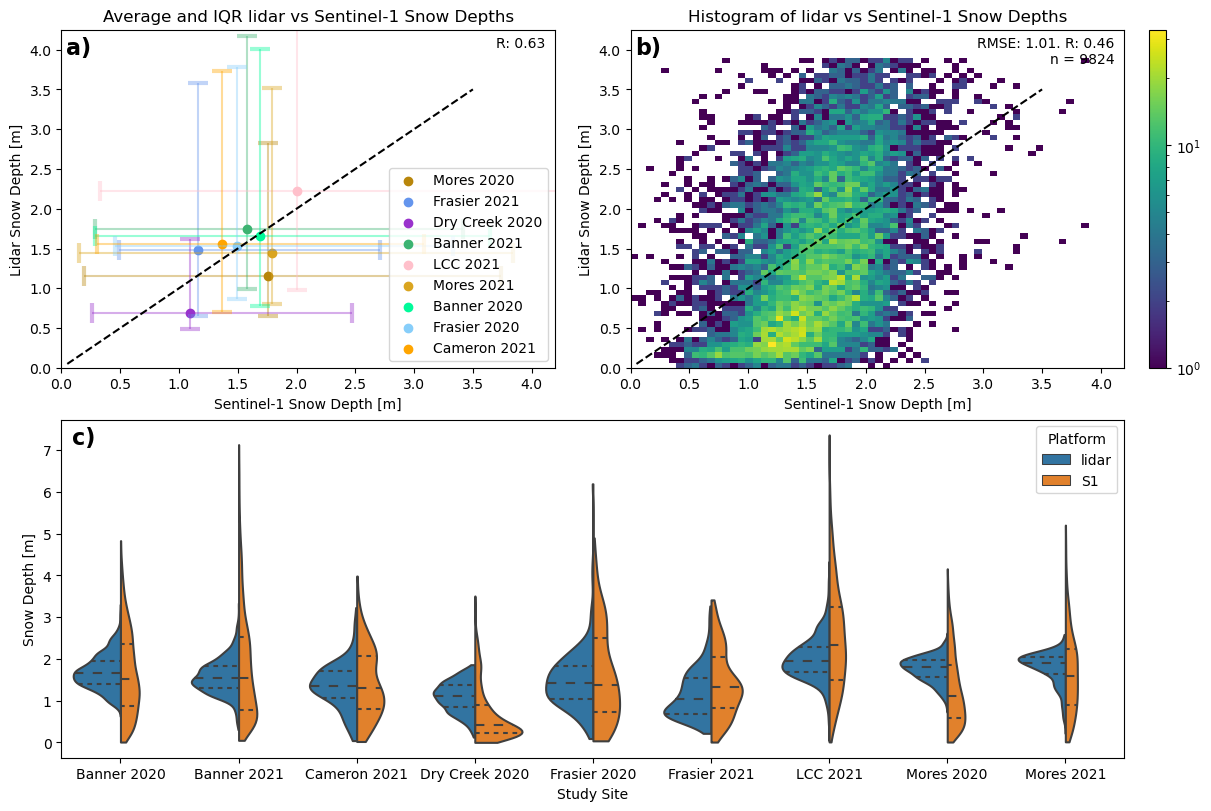

In [4]:
loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

fig = plt.figure(constrained_layout=True, figsize = (12, 8))
gs = fig.add_gridspec(2, 2)
f_ax1 = fig.add_subplot(gs[:1, 0])
f_ax2 = fig.add_subplot(gs[:1, 1])
f_ax_bottom = fig.add_subplot(gs[-1, :])

axes = [f_ax1, f_ax2]
all_axes = [f_ax1, f_ax2, f_ax_bottom]

# for 2d hist of all points
xs = []
ys = []

mean_x = []
mean_y = []

# adding violin plots per site
full = pd.DataFrame()
for stem, ds in dss.items():
    if stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
    site_name = stem.replace('_', ' ').split('-')[0].replace('Little Cottonwood', 'LCC')
    ds = ds.sel(time = im_date, method = 'nearest')
    ds = ds.where(ds['wet_snow'] == 0)
    ds = ds.where(ds['snow_depth'] > 0)
    # ds = ds.coarsen(x = 4, y = 4, boundary = 'pad').mean()
    # ds = ds.where(ds['fcf']<0.5)

    axes[0].errorbar(x = ds['lidar-sd'].mean(), y = ds['snow_depth'].mean(), \
                     yerr=ds['snow_depth'].quantile([0.25, 0.75]).values.reshape(2, 1), xerr=ds['lidar-sd'].quantile([0.25, 0.75]).values.reshape(2, 1), \
                        capsize = 7, capthick = 3, color = loc_colors[stem], alpha = 0.4)
    axes[0].scatter(x = ds['lidar-sd'].mean(), y = ds['snow_depth'].mean(), label = site_name, color = loc_colors[stem])
    mean_x.extend(ds['lidar-sd'].mean().values.ravel())
    mean_y.extend(ds['snow_depth'].mean().values.ravel())

    xs.extend(ds['lidar-sd'].values.ravel()) # .coarsen(x = 6, y = 6, boundary = 'pad').mean()
    ys.extend(ds['snow_depth'].values.ravel())

    # adding scale subplot
    spicy = ds['snow_depth'].where(~ds['lidar-sd'].isnull())
    lidar = ds['lidar-sd'].where(~ds['snow_depth'].isnull())

    scale = pd.DataFrame()
    scale['lidar'] = lidar.values.ravel()
    scale['S1'] = spicy.values.ravel()
    scale_violin = scale[['S1','lidar']].melt(var_name='Platform',value_name='snow_depth')
    scale_violin['Study Site'] = site_name
    full = pd.concat([full, scale_violin])

idx = (~np.isnan(xs)) & (~np.isnan(ys)) & (np.array(ys) > 0)
xs = np.array(xs)[idx]
ys = np.array(ys)[idx]
import matplotlib as mpl
h = axes[1].hist2d(xs, ys, bins = 60, range = [[0.0, 3.9], [0.0, 3.9]], norm = mpl.colors.LogNorm())
r, b, mae, rmse = get_stats(xs, ys)
axes[1].text(0.98, 0.98, f'RMSE: {rmse:.2f}. R: {r:.2f}\nn = {len(xs)}', transform = axes[1].transAxes, ha = 'right', va = 'top')

# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])

plt.colorbar(h[3], orientation='vertical')


for ax in axes:
    ax.set_ylim(0, 4.25)
    ax.set_xlim(0, 4.2)
    ax.set_xlabel('Sentinel-1 Snow Depth [m]')
    ax.set_ylabel('Lidar Snow Depth [m]')
    ax.plot([0.05, 3.5], [0.05, 3.5], linestyle = 'dashed', color = 'black')

r, b, mae, rmse = get_stats(mean_x, mean_y)
axes[0].text(0.98, 0.98, f'R: {r:.2f}', transform = axes[0].transAxes, ha = 'right', va = 'top')
axes[0].legend(loc = 'lower right')

sns.violinplot(data = full.sort_values('Study Site'), y = 'snow_depth', x = 'Study Site', hue = 'Platform', split=True, inner='quartile', cut=0, ax = f_ax_bottom)
f_ax_bottom.set_ylabel('Snow Depth [m]')

for ax, letter in zip(all_axes, ['a','b','c']):
    ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)

f_ax1.set_title('Average and IQR lidar vs Sentinel-1 Snow Depths')
f_ax2.set_title('Histogram of lidar vs Sentinel-1 Snow Depths')
plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/figures/overall/overall_3panel.png')

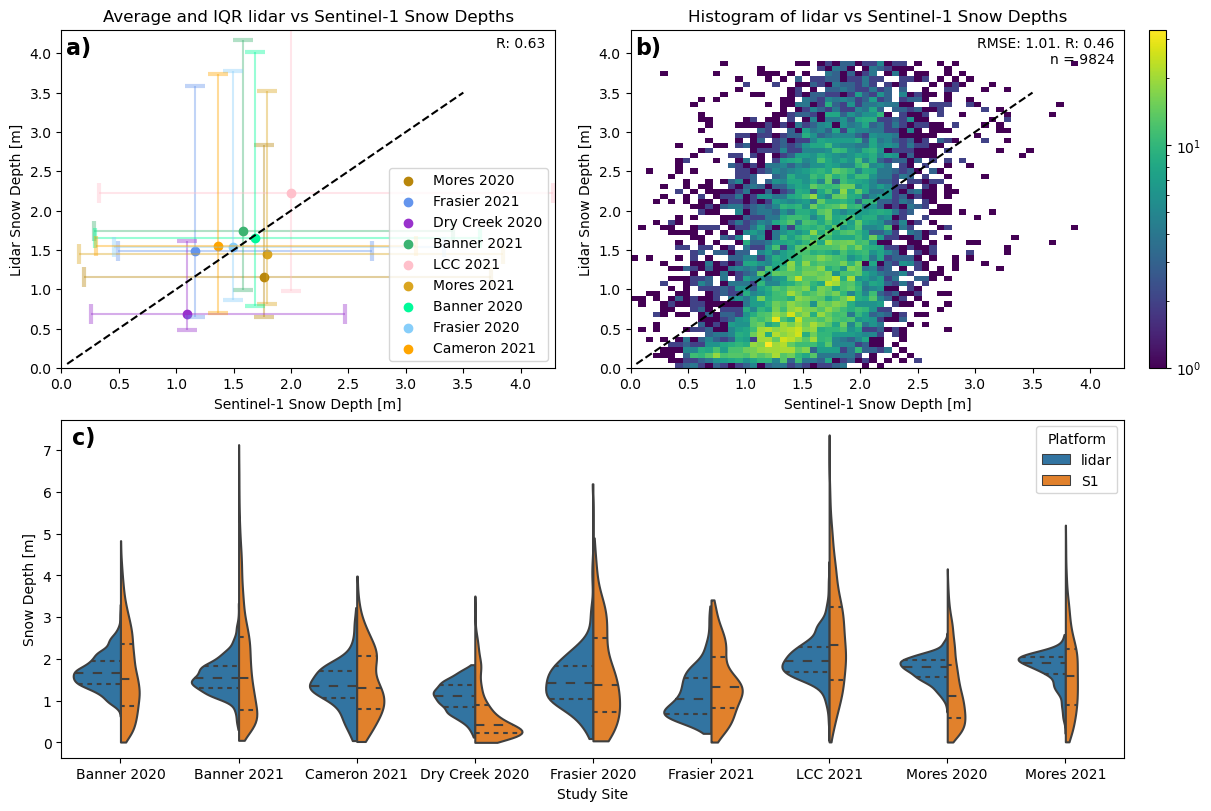

In [7]:
loc_colors = {'Banner_2020-02-18': 'mediumspringgreen', 'Banner_2021-03-15': 'mediumseagreen', 'Cameron_2021-03-19': 'orange', \
    'Dry_Creek_2020-02-19': 'darkorchid', 'Frasier_2020-02-11': 'lightskyblue', 'Frasier_2021-03-19': 'cornflowerblue', \
        'Little_Cottonwood_2021-03-18': 'pink', 'Mores_2020-02-09': 'darkgoldenrod', 'Mores_2021-03-15': 'goldenrod'}

fig = plt.figure(constrained_layout=True, figsize = (12, 8))
gs = fig.add_gridspec(2, 2)
f_ax1 = fig.add_subplot(gs[:1, 0])
f_ax2 = fig.add_subplot(gs[:1, 1])
f_ax_bottom = fig.add_subplot(gs[-1, :])

axes = [f_ax1, f_ax2]
all_axes = [f_ax1, f_ax2, f_ax_bottom]

# for 2d hist of all points
xs = []
ys = []

mean_x = []
mean_y = []

# adding violin plots per site
full = pd.DataFrame()
for stem, ds in dss.items():
    if stem == 'Frasier_2020-02-11':
        im_date = pd.to_datetime('2020-02-16')
    else:
        im_date = pd.to_datetime(ds.sel(time = ds.attrs['lidar-flight-time'], method = 'nearest').time.values.ravel()[0])
    site_name = stem.replace('_', ' ').split('-')[0].replace('Little Cottonwood', 'LCC')
    ds = ds.sel(time = im_date, method = 'nearest')
    ds = ds.where(ds['wet_snow'] == 0)
    ds = ds.where(ds['snow_depth'] > 0)
    # ds = ds.coarsen(x = 4, y = 4, boundary = 'pad').mean()
    # ds = ds.where(ds['fcf']<0.5)

    axes[0].errorbar(x = ds['lidar-sd'].mean(), y = ds['snow_depth'].mean(), \
                     yerr=ds['snow_depth'].quantile([0.25, 0.75]).values.reshape(2, 1), xerr=ds['lidar-sd'].quantile([0.25, 0.75]).values.reshape(2, 1), \
                        capsize = 7, capthick = 3, color = loc_colors[stem], alpha = 0.4)
    axes[0].scatter(x = ds['lidar-sd'].mean(), y = ds['snow_depth'].mean(), label = site_name, color = loc_colors[stem])
    mean_x.extend(ds['lidar-sd'].mean().values.ravel())
    mean_y.extend(ds['snow_depth'].mean().values.ravel())

    xs.extend(ds['lidar-sd'].values.ravel()) # .coarsen(x = 6, y = 6, boundary = 'pad').mean()
    ys.extend(ds['snow_depth'].values.ravel())

    # adding scale subplot
    spicy = ds['snow_depth'].where(~ds['lidar-sd'].isnull())
    lidar = ds['lidar-sd'].where(~ds['snow_depth'].isnull())

    scale = pd.DataFrame()
    scale['lidar'] = lidar.values.ravel()
    scale['S1'] = spicy.values.ravel()
    scale_violin = scale[['S1','lidar']].melt(var_name='Platform',value_name='snow_depth')
    scale_violin['Study Site'] = site_name
    full = pd.concat([full, scale_violin])

idx = (~np.isnan(xs)) & (~np.isnan(ys)) & (np.array(ys) > 0)
xs = np.array(xs)[idx]
ys = np.array(ys)[idx]
import matplotlib as mpl
h = axes[1].hist2d(xs, ys, bins = 60, range = [[0.0, 3.9], [0.0, 3.9]], norm = mpl.colors.LogNorm())
r, b, mae, rmse = get_stats(xs, ys)
axes[1].text(0.98, 0.98, f'RMSE: {rmse:.2f}. R: {r:.2f}\nn = {len(xs)}', transform = axes[1].transAxes, ha = 'right', va = 'top')

# divider = make_axes_locatable(axes[1])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])

plt.colorbar(h[3], orientation='vertical')


for ax in axes:
    ax.set_ylim(0, 4.3)
    ax.set_xlim(0, 4.3)
    ax.set_xlabel('Sentinel-1 Snow Depth [m]')
    ax.set_ylabel('Lidar Snow Depth [m]')
    ax.plot([0.05, 3.5], [0.05, 3.5], linestyle = 'dashed', color = 'black')

r, b, mae, rmse = get_stats(mean_x, mean_y)
axes[0].text(0.98, 0.98, f'R: {r:.2f}', transform = axes[0].transAxes, ha = 'right', va = 'top')
axes[0].legend(loc = 'lower right')

sns.violinplot(data = full.sort_values('Study Site'), y = 'snow_depth', x = 'Study Site', hue = 'Platform', split=True, inner='quartile', cut=0, ax = f_ax_bottom)
f_ax_bottom.set_ylabel('Snow Depth [m]')

for ax, letter in zip(all_axes, ['a','b','c']):
    ax.text(0.01, 0.98,f'{letter})', transform=ax.transAxes, ha = 'left', va = 'top', weight='bold', size = 16)

f_ax1.set_title('Average and IQR lidar vs Sentinel-1 Snow Depths')
f_ax2.set_title('Histogram of lidar vs Sentinel-1 Snow Depths')
plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/figures/overall/overall_3panel.png')